In [1]:
# Alex Rugg (arugg@ucar.edu)
# Warning: this code will not always work properly if cells are run out of order.

import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from netCDF4 import Dataset as ds
import metpy.calc as met
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
import math

# set path to where the data files are, should contain subdirectories 
# "huc_domains", "metsim_setup", "vic_setup", "vic_output"
datadir = '/glade/scratch/arugg/open_research/grl_2023' 

Create weight file: nearest_s2d_444x922_400x464.nc
Remove file nearest_s2d_444x922_400x464.nc


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Create weight file: nearest_s2d_33x47_496x928.nc
Remove file nearest_s2d_33x47_496x928.nc
Create weight file: conservative_496x928_33x47.nc
Remove file conservative_496x928_33x47.nc


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in true_divide
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


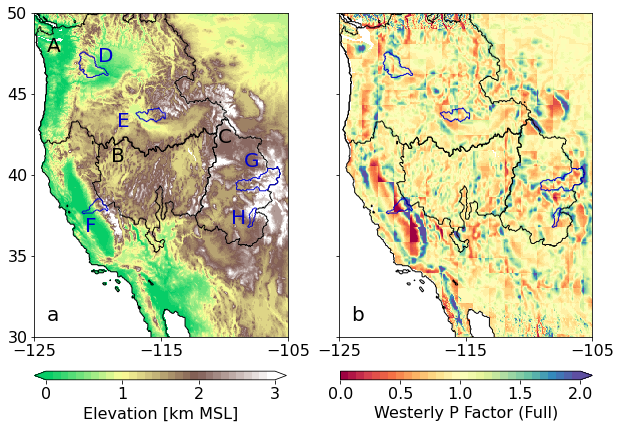

In [2]:
# Figure One: Map of domain, topography, watersheds

vicParams = xr.open_dataset(datadir+'/metsim_setup/westConus_vic_parameters.nc')

watersheds = xr.open_dataset(datadir+'/huc_domains/hucData02.nc').load()
huc02 = watersheds.data[48:448,0:464]
lat = watersheds.lat[48:448,0:464]
lon = watersheds.lon[48:448,0:464]
watersheds = xr.open_dataset(datadir+'/huc_domains/hucData08.nc').load()
huc08 = watersheds.data

huc12 = xr.open_dataset(datadir+'/huc_domains/huc12_6km.nc');

lon_b = lon[0,:]-(0.0625)/2;
lon_b = np.append(lon_b,lon[0,lon.shape[1]-2]+0.0625/2)
lat_b = lat[:,0]-(0.0625)/2;
lat_b = np.append(lat_b,lat[lat.shape[0]-2,0]+0.0625/2)
obsGrid = xr.Dataset({'lat': (['lat'], lat[:,0]),'lon': (['lon'], lon[0,:]),'lat_b': (['lat_b'], lat_b), 'lon_b': (['lon_b'], lon_b)})

lon_b = (huc12.lon.data[0,0:-1]+huc12.lon.data[0,1:])/2
lon_b = np.append(huc12.lon.data[0,0]-0.5*(huc12.lon.data[0,1]-huc12.lon.data[0,0]),lon_b)
lon_b = np.append(lon_b,huc12.lon.data[0,huc12.lon.shape[1]-1]+0.5*
                  (huc12.lon.data[0,huc12.lon.shape[1]-1]-huc12.lon.data[0,huc12.lon.shape[1]-2]))
lat_b = (huc12.lat.data[0:-1,0]+huc12.lat.data[1:,0])/2
lat_b = np.append(huc12.lat.data[0,0]-0.5*(huc12.lat.data[1,0]-huc12.lat.data[0,0]),lat_b)
lat_b = np.append(lat_b,huc12.lat.data[huc12.lat.shape[0]-1,0]+0.5*
                  (huc12.lat.data[huc12.lat.shape[0]-1,0]-huc12.lat.data[huc12.lat.shape[0]-2,0]))
huc12Grid = xr.Dataset({'lat': (['lat'], huc12.lat[:,0]),'lon': (['lon'], huc12.lon[0,:]),'lat_b': (['lat_b'], lat_b), 'lon_b': (['lon_b'], lon_b)})
regridder = xe.Regridder(huc12Grid,obsGrid,'nearest_s2d')
regridder.clean_weight_file()
huc12 = regridder(huc12.data)
huc12 = huc12.values

# Define boolean arrays for watersheds 

pacific = np.ones(huc12.shape)
pacific[huc02<12.5] = 0
pacific[huc02>13.5] = 0

upperCo = np.ones(huc12.shape)
upperCo[huc02<11.5] = 0
upperCo[huc02>12.5] = 0

greatBasin = np.ones(huc12.shape)
greatBasin[huc02<20.5] = 0
greatBasin[huc02>21.5] = 0

cameo = np.ones(huc12.shape)
cameo[huc08<14010000-0.5] = 0
cameo[huc08>14010009.5] = 0

tuolomne = np.ones(huc12.shape)
tuolomne[huc12<180400095232-0.5] = 0
tuolomne[huc12>180400095232.5] = 0

yakima = np.ones(huc12.shape)
yakima[huc08<17030000-0.5] = 0
yakima[huc08>17030009.5] = 0

animas = np.ones(huc12.shape)
animas[huc08<14080104-0.5] = 0
animas[huc08>14080104.5] = 0

boise = np.ones(huc12.shape)
boise[huc08<17050111-0.5] = 0
boise[huc08>17050114.5] = 0

continents = np.zeros(pacific.shape)
continents[~np.isnan(vicParams.elev)] = 1
continents[pacific>0.5] = True
continents[greatBasin>0.5] = True

# Map of VIC domain, topography, HUCs used
plt.rcParams.update({'font.size':16})
tmp1 = plt.get_cmap('terrain',40)
newcolors = tmp1(np.linspace(0, 1, 40))
cmap = ListedColormap(newcolors[10:,:])

fig, ax = plt.subplots(1,2,figsize=(10,6),sharey=True,sharex=True)
plt.subplots_adjust(bottom=0.2,top=0.95)
im = ax[0].pcolormesh(vicParams.lon,vicParams.lat,vicParams.elev/1000,vmin=0,vmax=3,cmap=cmap)
ax[0].set_xlim([-125,-105])
ax[0].set_ylim([30,50])
ax[0].set_xticks([-125,-115,-105])
ax[0].set_yticks([30,35,40,45,50])
ax[0].text(-124,31,'a',color='k',fontsize=20)
ax[0].contour(vicParams.lon,vicParams.lat,continents,
           levels=[0.5],colors='k',linewidths=1)
ax[0].contour(vicParams.lon,vicParams.lat,pacific,
           levels=[0.5],colors='k',linewidths=1)
ax[0].text(-124,47.6,'A',color='k',fontsize=20)
ax[0].contour(vicParams.lon,vicParams.lat,greatBasin,
           levels=[0.5],colors='k',linewidths=1)
ax[0].text(-119,40.8,'B',color='k',fontsize=20)
ax[0].contour(vicParams.lon,vicParams.lat,upperCo,
           levels=[0.5],colors='k',linewidths=1)
ax[0].text(-110.5,42,'C',color='k',fontsize=20)
ax[0].contour(vicParams.lon,vicParams.lat,yakima,
           levels=[0.5],colors='mediumblue',linewidths=1)
ax[0].text(-120,47,'D',color='mediumblue',fontsize=20)
ax[0].contour(vicParams.lon,vicParams.lat,boise,
           levels=[0.5],colors='mediumblue',linewidths=1)
ax[0].text(-118.5,43,'E',color='mediumblue',fontsize=20)
ax[0].contour(vicParams.lon,vicParams.lat,tuolomne,
           levels=[0.5],colors='mediumblue',linewidths=1)
ax[0].text(-121,36.5,'F',color='mediumblue',fontsize=20)
ax[0].contour(vicParams.lon,vicParams.lat,cameo,
           levels=[0.5],colors='mediumblue',linewidths=1)
ax[0].text(-108.5,40.5,'G',color='mediumblue',fontsize=20)
ax[0].contour(vicParams.lon,vicParams.lat,animas,
           levels=[0.5],colors='mediumblue',linewidths=1)
ax[0].text(-109.5,37,'H',color='mediumblue',fontsize=20)
cax2 = plt.axes([0.125, 0.1, 0.35, 0.02])
c2 = plt.colorbar(im,cax=cax2,extend='both',orientation='horizontal')
c2.set_label('Elevation [km MSL]')

# Precip Correction with Westerly winds
topoData = xr.open_dataset(datadir+'/topoData.nc')      
topoDif = topoData.topoHiRes - topoData.topoLoRes
maxElevDif100km = topoData.maxElev100km[4,:,:] - topoData.topoHiRes
minElevDif100km = topoData.minElev100km[4,:,:] - topoData.topoHiRes
minElevDif50km = topoData.minElev50km[4,:,:] - topoData.topoHiRes
wadjust = (1-0.000199*maxElevDif100km + 0.000216*minElevDif100km - 0.000675*minElevDif50km + 0.000557*topoDif)
#wadjust = (1 + 0.000557*topoDif)

# mass conservation
cesmGrid = xr.open_dataset(datadir+'/cesmGrid.nc')
obsGrid = xr.open_dataset(datadir+'/obsGrid.nc')

downscaler = xe.Regridder(cesmGrid,obsGrid,'nearest_s2d')
downscaler.clean_weight_file()
upscaler = xe.Regridder(obsGrid,cesmGrid,'conservative')
upscaler.clean_weight_file()

nonan = np.nan_to_num(wadjust, copy=True, nan=0.0)
upscaled = upscaler(nonan)
justones = np.ones(wadjust.shape)
justones[~np.isfinite(wadjust.values)]=0
justones_upscaled = upscaler(justones)
upscaled = (upscaled)/(justones_upscaled)
newaverage = downscaler(upscaled)
newaverage = np.maximum(newaverage,0.0000000000000000001) # avoid divide by zero error
wadjust = wadjust/newaverage

# plot
im = ax[1].pcolormesh(wadjust.lon,wadjust.lat,wadjust,vmin=0,vmax=2,cmap=plt.get_cmap('Spectral',30))
ax[1].set_xlim([-125,-105])
ax[1].set_ylim([30,50])
ax[1].set_xticks([-125,-115,-105])
ax[1].set_yticks([30,35,40,45,50])
ax[1].text(-124,31,'b',color='k',fontsize=20)
ax[1].contour(vicParams.lon,vicParams.lat,continents,
           levels=[0.5],colors='k',linewidths=1)
ax[1].contour(vicParams.lon,vicParams.lat,pacific,
           levels=[0.5],colors='k',linewidths=1)
ax[1].contour(vicParams.lon,vicParams.lat,greatBasin,
           levels=[0.5],colors='k',linewidths=1)
ax[1].contour(vicParams.lon,vicParams.lat,upperCo,
           levels=[0.5],colors='k',linewidths=1)
ax[1].contour(vicParams.lon,vicParams.lat,yakima,
           levels=[0.5],colors='mediumblue',linewidths=1)
ax[1].contour(vicParams.lon,vicParams.lat,boise,
           levels=[0.5],colors='mediumblue',linewidths=1)
ax[1].contour(vicParams.lon,vicParams.lat,tuolomne,
           levels=[0.5],colors='mediumblue',linewidths=1)
ax[1].contour(vicParams.lon,vicParams.lat,cameo,
           levels=[0.5],colors='mediumblue',linewidths=1)
ax[1].contour(vicParams.lon,vicParams.lat,animas,
           levels=[0.5],colors='mediumblue',linewidths=1)
cax2 = plt.axes([0.55, 0.1, 0.35, 0.02])
c2 = plt.colorbar(im,cax=cax2,extend='max',orientation='horizontal')
c2.set_label('Westerly P Factor (Full)')

plt.savefig('ruggEtAl_GRL_fig1', dpi=150)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/glade/u/ssg/ch/usr/jupy

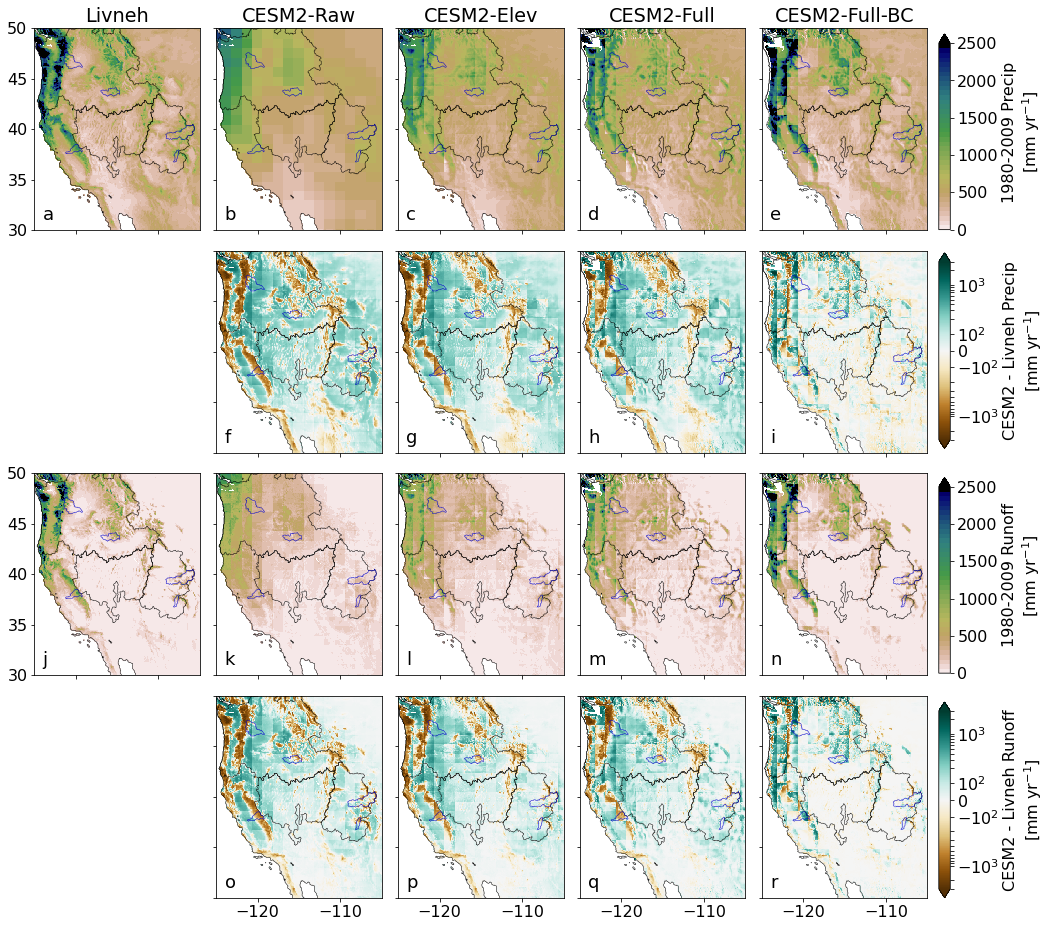

In [3]:
# Figure 2: Annual Mean Precip, Runoff Maps
mpl.rcParams.update({'font.size': 16})
tmp1 = plt.get_cmap('gist_earth_r',41)
newcolors = tmp1(np.linspace(0, 1, 41))
cmap = ListedColormap(newcolors[1:,:])

fig, axs = plt.subplots(4,5,figsize=(16,16),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0.1,hspace=0.1)
                  
# Current Precip (top row)
cntl = xr.open_dataset(datadir+'/metsim_setup/LivnehForcing_4MetSim_1960-2009_CNTL.nc')
cesm = xr.open_dataset(datadir+'/metsim_setup/LivnehForcing_4MetSim_1960-2009_CESM-1231.001.nc')
elev = xr.open_dataset(datadir+'/metsim_setup/LivnehForcing_4MetSim_1960-2009_TOPO-1231.001.nc')
ds = xr.open_dataset(datadir+'/metsim_setup/LivnehForcing_4MetSim_1960-2009_DSMC-1231.001.nc')
dsbc = xr.open_dataset(datadir+'/metsim_setup/LivnehForcing_4MetSim_1960-2009_DSBC-1231.001.nc')
istart = 273+365*19# index corresponding to Oct 1 of first year of averaging (1979)
iend = 18158 # index corresponding to Oct 1 of last year of averaging

tcntl = np.mean(cntl.prec.values[istart:iend,:,:],axis=0)
tcesm = np.mean(cesm.prec.values[istart:iend,:,:],axis=0)
telev = np.mean(elev.prec.values[istart:iend,:,:],axis=0)
tds= np.mean(ds.prec.values[istart:iend,:,:],axis=0)
tdsbc= np.mean(dsbc.prec.values[istart:iend,:,:],axis=0)
tcesm[np.isnan(tcntl)] = np.nan
telev[np.isnan(tcntl)] = np.nan

im = axs[0,0].pcolormesh(cntl.lon,cntl.lat,tcntl*365,
        shading='auto',norm=colors.Normalize(vmin=0,vmax=2500),cmap=cmap)
axs[0,0].text(-124,31,'a',fontsize=18)
axs[0,1].pcolormesh(cntl.lon,cntl.lat,tcesm*365,
        shading='auto',norm=colors.Normalize(vmin=0,vmax=2500),cmap=cmap)
axs[0,1].text(-124,31,'b',fontsize=18)
axs[0,2].pcolormesh(cntl.lon,cntl.lat,telev*365,
        shading='auto',norm=colors.Normalize(vmin=0,vmax=2500),cmap=cmap)
axs[0,2].text(-124,31,'c',fontsize=18)
axs[0,3].pcolormesh(cntl.lon,cntl.lat,tds*365,
        shading='auto',norm=colors.Normalize(vmin=0,vmax=2500),cmap=cmap)
axs[0,3].text(-124,31,'d',fontsize=18)
axs[0,4].pcolormesh(cntl.lon,cntl.lat,tdsbc*365,
        shading='auto',norm=colors.Normalize(vmin=0,vmax=2500),cmap=cmap)
axs[0,4].text(-124,31,'e',fontsize=18)
cax2 = plt.axes([0.91, 0.705, 0.01, 0.17])
c2 = plt.colorbar(im,cax=cax2,extend='max',orientation='vertical')
c2.set_label('1980-2009 Precip\n[mm yr$^{-1}$]')
  
# Precip Dif from Obs (2nd row)
im = axs[1,1].pcolormesh(cntl.lon,cntl.lat,tcesm*365 - tcntl*365,
        shading='auto',norm=colors.SymLogNorm(100,0.5,vmin=-3000,vmax=3000),cmap='BrBG')
axs[1,1].text(-124,31,'f',fontsize=18)
axs[1,2].pcolormesh(cntl.lon,cntl.lat,telev*365 - tcntl*365,
        shading='auto',norm=colors.SymLogNorm(100,0.5,vmin=-3000,vmax=3000),cmap='BrBG')
axs[1,2].text(-124,31,'g',fontsize=18)
axs[1,3].pcolormesh(cntl.lon,cntl.lat,tds*365 - tcntl*365,
        shading='auto',norm=colors.SymLogNorm(100,0.5,vmin=-3000,vmax=3000),cmap='BrBG')
axs[1,3].text(-124,31,'h',fontsize=18)
axs[1,4].pcolormesh(cntl.lon,cntl.lat,tdsbc*365 - tcntl*365,
        shading='auto',norm=colors.SymLogNorm(100,0.5,vmin=-3000,vmax=3000),cmap='BrBG')
axs[1,4].text(-124,31,'i',fontsize=18)
cax2 = plt.axes([0.91, 0.515, 0.01, 0.17])
c2 = plt.colorbar(im,cax=cax2,extend='both',orientation='vertical')
c2.set_label('CESM2 - Livneh Precip\n[mm yr$^{-1}$]')

# Current Streamflow (3rd row)
cntl = xr.open_dataset(datadir+'/vic_output/seasonalMeans_1980-2009_CNTL.nc')
cesm = xr.open_dataset(datadir+'/vic_output/seasonalMeans_1980-2009_CESM.nc')
elev = xr.open_dataset(datadir+'/vic_output/seasonalMeans_1980-2009_TOPO.nc')
ds = xr.open_dataset(datadir+'/vic_output/seasonalMeans_1980-2009_DSMC.nc')
dsbc = xr.open_dataset(datadir+'/vic_output/seasonalMeans_1980-2009_DSBC.nc')

im = axs[2,0].pcolormesh(cntl.lon,cntl.lat,cntl.STREAMFLOW.values[0,:,:]*365,
        shading='auto',norm=colors.Normalize(vmin=0,vmax=2500),cmap=cmap)
axs[2,0].text(-124,31,'j',fontsize=18)
axs[2,1].pcolormesh(cntl.lon,cntl.lat,cesm.STREAMFLOW.values[0,:,:]*365,
        shading='auto',norm=colors.Normalize(vmin=0,vmax=2500),cmap=cmap)
axs[2,1].text(-124,31,'k',fontsize=18)
axs[2,2].pcolormesh(cntl.lon,cntl.lat,elev.STREAMFLOW.values[0,:,:]*365,
        shading='auto',norm=colors.Normalize(vmin=0,vmax=2500),cmap=cmap)
axs[2,2].text(-124,31,'l',fontsize=18)
axs[2,3].pcolormesh(cntl.lon,cntl.lat,ds.STREAMFLOW.values[0,:,:]*365,
        shading='auto',norm=colors.Normalize(vmin=0,vmax=2500),cmap=cmap)
axs[2,3].text(-124,31,'m',fontsize=18)
axs[2,4].pcolormesh(cntl.lon,cntl.lat,dsbc.STREAMFLOW.values[0,:,:]*365,
        shading='auto',norm=colors.Normalize(vmin=0,vmax=2500),cmap=cmap)
axs[2,4].text(-124,31,'n',fontsize=18)
cax2 = plt.axes([0.91, 0.32, 0.01, 0.17])
c2 = plt.colorbar(im,cax=cax2,extend='max',orientation='vertical')
c2.set_label('1980-2009 Runoff\n[mm yr$^{-1}$]')

# Runoff Dif from Obs (4th row)
im = axs[3,1].pcolormesh(cntl.lon,cntl.lat,cesm.STREAMFLOW.values[0,:,:]*365-cntl.STREAMFLOW.values[0,:,:]*365,
        shading='auto',norm=colors.SymLogNorm(100,0.5,vmin=-3000,vmax=3000),cmap='BrBG')
axs[3,1].text(-124,31,'o',fontsize=18)
axs[3,2].pcolormesh(cntl.lon,cntl.lat,elev.STREAMFLOW.values[0,:,:]*365-cntl.STREAMFLOW.values[0,:,:]*365,
        shading='auto',norm=colors.SymLogNorm(100,0.5,vmin=-3000,vmax=3000),cmap='BrBG')
axs[3,2].text(-124,31,'p',fontsize=18)
axs[3,3].pcolormesh(cntl.lon,cntl.lat,ds.STREAMFLOW.values[0,:,:]*365-cntl.STREAMFLOW.values[0,:,:]*365,
        shading='auto',norm=colors.SymLogNorm(100,0.5,vmin=-3000,vmax=3000),cmap='BrBG')
axs[3,3].text(-124,31,'q',fontsize=18)
axs[3,4].pcolormesh(cntl.lon,cntl.lat,dsbc.STREAMFLOW.values[0,:,:]*365-cntl.STREAMFLOW.values[0,:,:]*365,
        shading='auto',norm=colors.SymLogNorm(100,0.5,vmin=-3000,vmax=3000),cmap='BrBG')
axs[3,4].text(-124,31,'r',fontsize=18)
cax2 = plt.axes([0.91, 0.125, 0.01, 0.17])
c2 = plt.colorbar(im,cax=cax2,extend='both',orientation='vertical')
c2.set_label('CESM2 - Livneh Runoff\n[mm yr$^{-1}$]')


# Add axis labels, watershed outlines
axs[0,0].set_title('Livneh')
axs[0,1].set_title('CESM2-Raw')
axs[0,2].set_title('CESM2-Elev')
axs[0,3].set_title('CESM2-Full')
axs[0,4].set_title('CESM2-Full-BC')

# Add region outlines

for i in [0,1,2,3,4]:
    for j in [0,1,2,3]:
        axs[j,i].contour(cntl.lon,cntl.lat,continents,
                    levels=[0.5],colors='k',linewidths=0.5)
        axs[j,i].contour(cntl.lon,cntl.lat,pacific,
                    levels=[0.5],colors='k',linewidths=0.5)
        axs[j,i].contour(cntl.lon,cntl.lat,greatBasin,
                    levels=[0.5],colors='k',linewidths=0.5)
        axs[j,i].contour(cntl.lon,cntl.lat,upperCo,
                    levels=[0.5],colors='k',linewidths=0.5)
        axs[j,i].contour(cntl.lon,cntl.lat,yakima,
                    levels=[0.5],colors='mediumblue',linewidths=0.5)
        axs[j,i].contour(cntl.lon,cntl.lat,cameo,
                    levels=[0.5],colors='mediumblue',linewidths=0.5)
        axs[j,i].contour(cntl.lon,cntl.lat,tuolomne,
                    levels=[0.5],colors='mediumblue',linewidths=0.5)
        axs[j,i].contour(cntl.lon,cntl.lat,animas,
                    levels=[0.5],colors='mediumblue',linewidths=0.5)
        axs[j,i].contour(cntl.lon,cntl.lat,boise,
                    levels=[0.5],colors='mediumblue',linewidths=0.5)

fig.delaxes(axs[1,0])
fig.delaxes(axs[3,0])
axs[0,0].set_xlim([-125,-105])
axs[0,0].set_ylim([30,50])
axs[0,0].set_xticks([-120,-110])
axs[0,0].set_yticks([30,35,40,45,50])
plt.savefig('ruggEtAl_GRL_fig2', dpi=150)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  app.launch_new_instance()
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argume

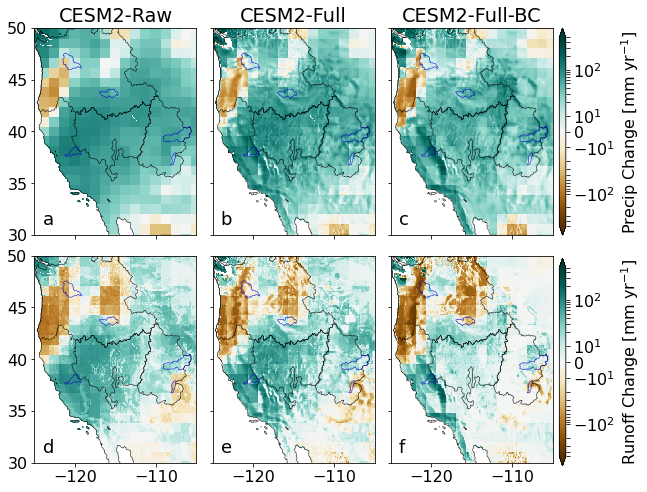

In [4]:
# Figure S1:  Annual Mean Precip, Runoff Maps
cntl = xr.open_dataset(datadir+'/vic_output/seasonalMeans_1980-2009_CNTL.nc')
cesm = xr.open_dataset(datadir+'/vic_output/seasonalMeans_1980-2009_CESM.nc')
ds = xr.open_dataset(datadir+'/vic_output/seasonalMeans_1980-2009_DSMC.nc')
dsbc = xr.open_dataset(datadir+'/vic_output/seasonalMeans_1980-2009_DSBC.nc')

ds_future = xr.open_dataset(datadir+'/vic_output/seasonalMeans_2070-2099_DSMC.nc')
dsbc_future = xr.open_dataset(datadir+'/vic_output/seasonalMeans_2070-2099_DSBC.nc')
cesm_future = xr.open_dataset(datadir+'/vic_output/seasonalMeans_2070-2099_CESM.nc')

fig, axs = plt.subplots(2,3,figsize=(9,8),sharey=True,sharex=True)
plt.subplots_adjust(left=0.05,right=0.85,wspace=0.1,hspace=0.1)

# Future Precip Change (top row)
im = axs[0,0].pcolormesh(cntl.lon,cntl.lat,cesm_future.PREC.values[0,:,:]*365 - cesm.PREC.values[0,:,:]*365,
        shading='auto',norm=colors.SymLogNorm(10,0.5,vmin=-500,vmax=500),cmap='BrBG')
axs[0,0].text(-124,31,'a',fontsize=18)
axs[0,1].pcolormesh(cntl.lon,cntl.lat,ds_future.PREC.values[0,:,:]*365-ds.PREC.values[0,:,:]*365,
        shading='auto',norm=colors.SymLogNorm(10,0.5,vmin=-500,vmax=500),cmap='BrBG')
axs[0,1].text(-124,31,'b',fontsize=18)
axs[0,2].pcolormesh(cntl.lon,cntl.lat,dsbc_future.PREC.values[0,:,:]*365 - dsbc.PREC.values[0,:,:]*365,
        shading='auto',norm=colors.SymLogNorm(10,0.5,vmin=-500,vmax=500),cmap='BrBG')
axs[0,2].text(-124,31,'c',fontsize=18)
cax2 = plt.axes([0.86, 0.52, 0.01, 0.36])
c2 = plt.colorbar(im,cax=cax2,extend='both',orientation='vertical')
c2.set_label('Precip Change [mm yr$^{-1}$]')

# Future Streamflow Change (bottom row)
im = axs[1,0].pcolormesh(cntl.lon,cntl.lat,cesm_future.STREAMFLOW.values[0,:,:]*365 - cesm.STREAMFLOW.values[0,:,:]*365,
    shading='auto',norm=colors.SymLogNorm(10,0.5,vmin=-500,vmax=500),cmap='BrBG')
axs[1,0].text(-124,31,'d',fontsize=18)
axs[1,1].pcolormesh(cntl.lon,cntl.lat,ds_future.STREAMFLOW.values[0,:,:]*365-ds.STREAMFLOW.values[0,:,:]*365,
    shading='auto',norm=colors.SymLogNorm(10,0.5,vmin=-500,vmax=500),cmap='BrBG')
axs[1,1].text(-124,31,'e',fontsize=18)
axs[1,2].pcolormesh(cntl.lon,cntl.lat,dsbc_future.STREAMFLOW.values[0,:,:]*365 - dsbc.STREAMFLOW.values[0,:,:]*365,
    shading='auto',norm=colors.SymLogNorm(10,0.5,vmin=-500,vmax=500),cmap='BrBG')
axs[1,2].text(-124,31,'f',fontsize=18)
cax2 = plt.axes([0.86, 0.12, 0.01, 0.36])
c2 = plt.colorbar(im,cax=cax2,extend='both',orientation='vertical')
c2.set_label('Runoff Change [mm yr$^{-1}$]')

# Add axis labels, watershed outlines
axs[0,0].set_title('CESM2-Raw')
axs[0,1].set_title('CESM2-Full')
axs[0,2].set_title('CESM2-Full-BC')

for i in [0,1,2]:
    for j in [0,1]:
        axs[j,i].contour(cntl.lon,cntl.lat,continents,
                    levels=[0.5],colors='k',linewidths=0.5)
        axs[j,i].contour(cntl.lon,cntl.lat,pacific,
                    levels=[0.5],colors='k',linewidths=0.5)
        axs[j,i].contour(cntl.lon,cntl.lat,greatBasin,
                    levels=[0.5],colors='k',linewidths=0.5)
        axs[j,i].contour(cntl.lon,cntl.lat,upperCo,
                    levels=[0.5],colors='k',linewidths=0.5)
        axs[j,i].contour(cntl.lon,cntl.lat,yakima,
                    levels=[0.5],colors='mediumblue',linewidths=0.5)
        axs[j,i].contour(cntl.lon,cntl.lat,cameo,
                    levels=[0.5],colors='mediumblue',linewidths=0.5)
        axs[j,i].contour(cntl.lon,cntl.lat,tuolomne,
                    levels=[0.5],colors='mediumblue',linewidths=0.5)
        axs[j,i].contour(cntl.lon,cntl.lat,animas,
                    levels=[0.5],colors='mediumblue',linewidths=0.5)
        axs[j,i].contour(cntl.lon,cntl.lat,boise,
                    levels=[0.5],colors='mediumblue',linewidths=0.5)
        
axs[0,0].set_xlim([-125,-105])
axs[0,0].set_ylim([30,50])
axs[0,0].set_xticks([-120,-110])
axs[0,0].set_yticks([30,35,40,45,50])
plt.savefig('ruggEtAl_GRL_figS1', dpi=150)

In [5]:
# define a smoothing function
def smooth(data,n):
    databig = np.empty([data.shape[0]+n-1])
    databig[0:math.floor(n/2)] = data[len(data)-math.floor(n/2):]
    databig[math.floor(n/2):len(data)+math.floor(n/2)] = data[:]
    databig[len(data)+math.floor(n/2):] = data[0:math.floor(n/2)]
    datasmoothed = np.convolve(databig,np.ones([n,])/n,'valid')
    return datasmoothed

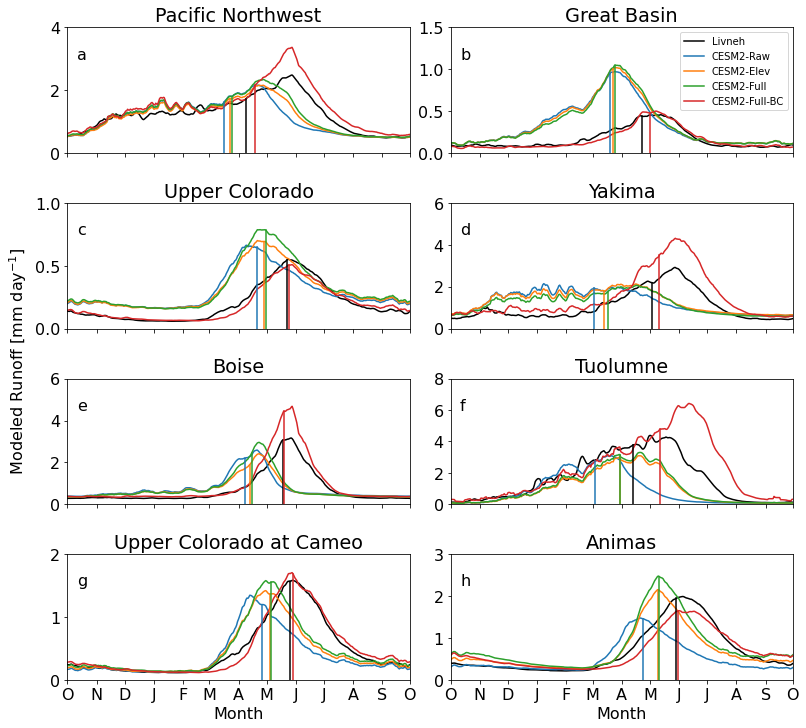

In [6]:
# Figure 3
cntl = xr.open_dataset(datadir+'/vic_output/seasonalMeans_1980-2009_CNTL.nc')
cesm = xr.open_dataset(datadir+'/vic_output/seasonalMeans_1980-2009_CESM.nc')
elev = xr.open_dataset(datadir+'/vic_output/seasonalMeans_1980-2009_TOPO.nc')
ds = xr.open_dataset(datadir+'/vic_output/seasonalMeans_1980-2009_DSMC.nc')
dsbc = xr.open_dataset(datadir+'/vic_output/seasonalMeans_1980-2009_DSBC.nc')

cntlSf = np.transpose(cntl.MEAN_STREAMFLOW.values,[1,2,0])
cesmSf = np.transpose(cesm.MEAN_STREAMFLOW.values,[1,2,0])
elevSf = np.transpose(elev.MEAN_STREAMFLOW.values,[1,2,0])
dsbcSf = np.transpose(dsbc.MEAN_STREAMFLOW.values,[1,2,0])
dsmcSf = np.transpose(ds.MEAN_STREAMFLOW.values,[1,2,0])

# Plotting
plt.rcParams.update({'font.size':16})
fig, axs = plt.subplots(4,2,figsize=(13,12),sharey=False,sharex=True)
plt.subplots_adjust(wspace=0.12,hspace=0.4)

xticks = [0, 31, 61, 92, 123, 151, 182, 212, 243, 273, 304, 335, 364]
midMonth = (np.array(xticks[0:-1])+np.array(xticks[1:]))/2
xlabs = ['O','N','D','J','F','M','A','M','J',
         'J','A','S','O']

rmse = np.zeros([4,8])
medDay = np.zeros([5,8])
i = 0

names = ['Pacific Northwest','Great Basin','Upper Colorado','Yakima','Boise','Tuolumne','Upper Colorado at Cameo','Animas']
letters = ['a','b','c','d','e','f','g','h']
ymax = [4,1.5,1,6,6,8,2,3]
for shed in [pacific, greatBasin, upperCo, yakima, boise, tuolomne, cameo, animas]:
    rmse[0,i] = np.sqrt(np.mean((smooth(np.nanmean(cntlSf[shed>0.5],0),7)-
                                smooth(np.nanmean(cesmSf[shed>0.5],0),7))**2))
    rmse[1,i] = np.sqrt(np.mean((smooth(np.nanmean(cntlSf[shed>0.5],0),7)-
                                smooth(np.nanmean(elevSf[shed>0.5],0),7))**2))
    rmse[2,i] = np.sqrt(np.mean((smooth(np.nanmean(cntlSf[shed>0.5],0),7)-
                                smooth(np.nanmean(dsmcSf[shed>0.5],0),7))**2))
    rmse[3,i] = np.sqrt(np.mean((smooth(np.nanmean(cntlSf[shed>0.5],0),7)-
                                smooth(np.nanmean(dsbcSf[shed>0.5],0),7))**2))
    tmp = np.cumsum(smooth(np.nanmean(cntlSf[shed>0.5],0),7))
    ind = np.argwhere(tmp>=0.5*np.nanmax(tmp))
    medDay[0,i] = np.nanmin(ind)
    tmp = np.cumsum(smooth(np.nanmean(cesmSf[shed>0.5],0),7))
    ind = np.argwhere(tmp>=0.5*np.nanmax(tmp))
    medDay[1,i] = np.nanmin(ind)
    tmp = np.cumsum(smooth(np.nanmean(elevSf[shed>0.5],0),7))
    ind = np.argwhere(tmp>=0.5*np.nanmax(tmp))
    medDay[2,i] = np.nanmin(ind)
    tmp = np.cumsum(smooth(np.nanmean(dsmcSf[shed>0.5],0),7))
    ind = np.argwhere(tmp>=0.5*np.nanmax(tmp))
    medDay[3,i] = np.nanmin(ind)
    tmp = np.cumsum(smooth(np.nanmean(dsbcSf[shed>0.5],0),7))
    ind = np.argwhere(tmp>=0.5*np.nanmax(tmp))
    medDay[4,i] = np.nanmin(ind)

    axs[math.floor(i/2),i%2].plot(smooth(np.nanmean(cntlSf[shed>0.5],0),7),'k')
    axs[math.floor(i/2),i%2].plot(smooth(np.nanmean(cesmSf[shed>0.5],0),7))
    axs[math.floor(i/2),i%2].plot(smooth(np.nanmean(elevSf[shed>0.5],0),7))
    axs[math.floor(i/2),i%2].plot(smooth(np.nanmean(dsmcSf[shed>0.5],0),7))
    axs[math.floor(i/2),i%2].plot(smooth(np.nanmean(dsbcSf[shed>0.5],0),7))
    axs[math.floor(i/2),i%2].plot([medDay[0,i],medDay[0,i]],[smooth(np.nanmean(cntlSf[shed>0.5],0),7)[np.int_(medDay[0,i])],0],'k')
    axs[math.floor(i/2),i%2].plot([medDay[1,i],medDay[1,i]],[smooth(np.nanmean(cesmSf[shed>0.5],0),7)[np.int_(medDay[1,i])],0],color='tab:blue')
    axs[math.floor(i/2),i%2].plot([medDay[2,i],medDay[2,i]],[smooth(np.nanmean(elevSf[shed>0.5],0),7)[np.int_(medDay[2,i])],0],color='tab:orange')
    axs[math.floor(i/2),i%2].plot([medDay[3,i],medDay[3,i]],[smooth(np.nanmean(dsmcSf[shed>0.5],0),7)[np.int_(medDay[3,i])],0],color='tab:green')
    axs[math.floor(i/2),i%2].plot([medDay[4,i],medDay[4,i]],[smooth(np.nanmean(dsbcSf[shed>0.5],0),7)[np.int_(medDay[4,i])],0],color='tab:red')
    axs[math.floor(i/2),i%2].set_title(names[i])
    axs[math.floor(i/2),i%2].set_xlim([0,364])
    axs[math.floor(i/2),i%2].text(10,ymax[i]*6/8,letters[i])
    axs[math.floor(i/2),i%2].set_xticks(xticks)
    axs[math.floor(i/2),i%2].set_xticklabels(xlabs)
    axs[math.floor(i/2),i%2].set_ylim([0,ymax[i]])
    
    i = i+1
    
axs[2,0].set_ylabel('\t\t\t\tModeled Runoff [mm day$^{-1}$]\n')
axs[0,1].legend(['Livneh','CESM2-Raw','CESM2-Elev','CESM2-Full','CESM2-Full-BC'],loc='upper right',fontsize=10)
axs[3,0].set_xlabel('Month')
axs[3,1].set_xlabel('Month')
axs[2,1].set_yticks([0,2,4,6,8])

plt.savefig('ruggEtAl_GRL_fig3', dpi=150)

In [26]:
rmse

array([[0.45231084, 0.26995123, 0.15411506, 0.87380903, 0.8265918 ,
        1.43026   , 0.36075521, 0.48585496],
       [0.34297197, 0.27503692, 0.14682498, 0.77927609, 0.73574337,
        0.97379511, 0.28741058, 0.32363709],
       [0.31023872, 0.27421037, 0.16873343, 0.70518093, 0.77576025,
        0.90066734, 0.27580923, 0.35984508],
       [0.31208634, 0.02943349, 0.02899355, 0.62232559, 0.40901896,
        1.29955239, 0.07360748, 0.17929813]])

In [39]:
medDay[1:,:]-medDay[0,:]

array([[-23., -34., -32., -61., -40., -40., -30., -35.],
       [-17., -31., -25., -51., -35., -14., -22., -19.],
       [-15., -29., -23., -47., -33., -14., -20., -18.],
       [ 10.,   8.,   2.,   8.,   1.,  29.,   3.,   2.]])

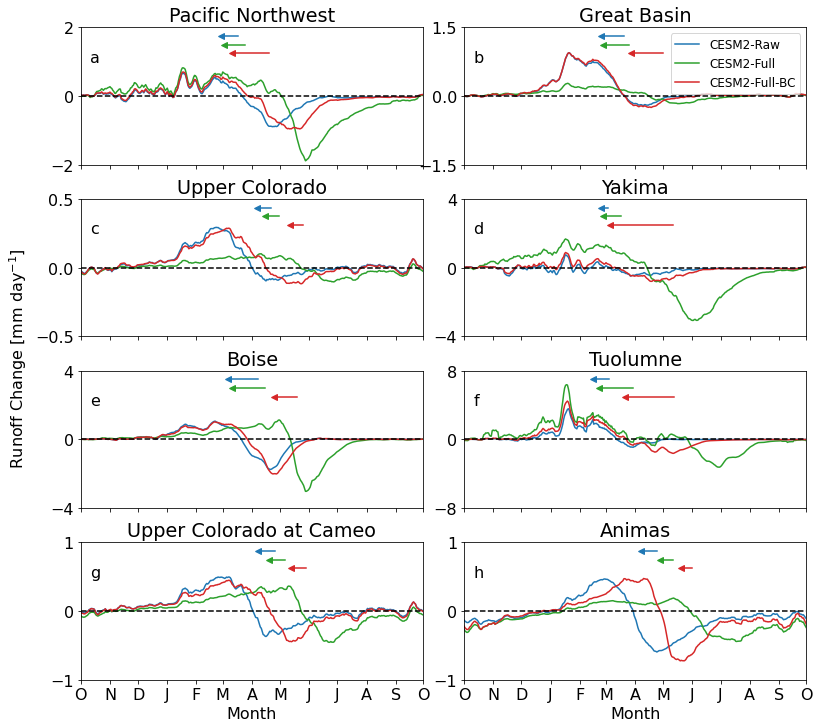

In [7]:
# Figure S2

plt.rcParams.update({'font.size':16})
cesm_future = xr.open_dataset(datadir+'/vic_output/seasonalMeans_2070-2099_CESM.nc')
ds_future  = xr.open_dataset(datadir+'/vic_output/seasonalMeans_2070-2099_DSMC.nc')
dsbc_future  = xr.open_dataset(datadir+'/vic_output/seasonalMeans_2070-2099_DSBC.nc')
cesm = xr.open_dataset(datadir+'/vic_output/seasonalMeans_1980-2009_CESM.nc')
ds = xr.open_dataset(datadir+'/vic_output/seasonalMeans_1980-2009_DSMC.nc')
dsbc = xr.open_dataset(datadir+'/vic_output/seasonalMeans_1980-2009_DSBC.nc')

cesmSf = np.transpose(cesm_future.MEAN_STREAMFLOW.values-cesm.MEAN_STREAMFLOW.values,[1,2,0])
dsbcSf = np.transpose(dsbc_future.MEAN_STREAMFLOW.values-dsbc.MEAN_STREAMFLOW.values,[1,2,0])
dsmcSf = np.transpose(ds_future.MEAN_STREAMFLOW.values-ds.MEAN_STREAMFLOW.values,[1,2,0])

fig, axs = plt.subplots(4,2,figsize=(13,12),sharey=False,sharex=True)
plt.subplots_adjust(wspace=0.12,hspace=0.25)

xticks = [0, 31, 61, 92, 123, 151, 182, 212, 243, 273, 304, 335, 364]
xlabs = ['O','N','D','J','F','M','A','M','J','J','A','S','O']

medDayFuture = np.zeros([3,8])
i = 0

names = ['Pacific Northwest','Great Basin','Upper Colorado',
         'Yakima','Boise','Tuolumne','Upper Colorado at Cameo','Animas']
letters = ['a','b','c','d','e','f','g','h','i','j']
ymax = [2, 1.5, 0.5, 4, 4, 8, 1, 1]
for shed in [pacific, greatBasin, upperCo, yakima, boise, tuolomne, cameo, animas]:
    tmp = np.cumsum(smooth(np.nanmean(np.transpose(cesm_future.MEAN_STREAMFLOW.values,[1,2,0])[shed>0.5],0),7))
    ind = np.argwhere(tmp>=0.5*np.nanmax(tmp))
    medDayFuture[0,i] = np.nanmin(ind)
    tmp = np.cumsum(smooth(np.nanmean(np.transpose(ds_future.MEAN_STREAMFLOW.values,[1,2,0])[shed>0.5],0),7))
    ind = np.argwhere(tmp>=0.5*np.nanmax(tmp))
    medDayFuture[1,i] = np.nanmin(ind)
    tmp = np.cumsum(smooth(np.nanmean(np.transpose(dsbc_future.MEAN_STREAMFLOW.values,[1,2,0])[shed>0.5],0),7))
    ind = np.argwhere(tmp>=0.5*np.nanmax(tmp))
    medDayFuture[2,i] = np.nanmin(ind)
    
    axs[math.floor(i/2),i%2].plot(smooth(np.nanmean(cesmSf[shed>0.5],0),7),color='tab:blue')
    axs[math.floor(i/2),i%2].plot(smooth(np.nanmean(dsbcSf[shed>0.5],0),7),color='tab:green')
    axs[math.floor(i/2),i%2].plot(smooth(np.nanmean(dsmcSf[shed>0.5],0),7),color='tab:red')

    axs[math.floor(i/2),i%2].plot([medDay[1,i],medDayFuture[0,i]],[ymax[i]*7/8,ymax[i]*7/8],'-',color='tab:blue')
    axs[math.floor(i/2),i%2].plot([medDay[3,i],medDayFuture[1,i]],[ymax[i]*3/4,ymax[i]*3/4],'-',color='tab:green')
    axs[math.floor(i/2),i%2].plot([medDay[4,i],medDayFuture[2,i]],[ymax[i]*5/8,ymax[i]*5/8],'-',color='tab:red')
    colors = ['tab:blue','tab:green','tab:red']
    for j in [0]:
        if medDayFuture[j,i]>medDay[j+1,i]:
            axs[math.floor(i/2),i%2].plot([medDayFuture[j,i]],[ymax[i]*(7/8-1/8*j)],'>',color=colors[j])
        elif medDayFuture[j,i]<medDay[j+1,i]:
            axs[math.floor(i/2),i%2].plot([medDayFuture[j,i]],[ymax[i]*(7/8-1/8*j)],'<',color=colors[j])
        else:
            axs[math.floor(i/2),i%2].plot([medDayFuture[j,i]],[ymax[i]*(7/8-1/8*j)],'o',color=colors[j])
    
    for j in [1,2]:
        if medDayFuture[j,i]>medDay[j+2,i]:
            axs[math.floor(i/2),i%2].plot([medDayFuture[j,i]],[ymax[i]*(7/8-1/8*j)],'>',color=colors[j])
        elif medDayFuture[j,i]<medDay[j+2,i]:
            axs[math.floor(i/2),i%2].plot([medDayFuture[j,i]],[ymax[i]*(7/8-1/8*j)],'<',color=colors[j])
        else:
            axs[math.floor(i/2),i%2].plot([medDayFuture[j,i]],[ymax[i]*(7/8-1/8*j)],'o',color=colors[j])
    
    axs[math.floor(i/2),i%2].plot([0,364],[0,0],'--k')
    axs[math.floor(i/2),i%2].set_title(names[i])
    axs[math.floor(i/2),i%2].set_xlim([0,364])
    axs[math.floor(i/2),i%2].set_ylim([-ymax[i],ymax[i]])
    axs[math.floor(i/2),i%2].text(10,ymax[i]*4/8,letters[i])
    axs[math.floor(i/2),i%2].set_xticks(xticks)
    axs[math.floor(i/2),i%2].set_yticks([-ymax[i],0,ymax[i]])
    axs[math.floor(i/2),i%2].set_xticklabels(xlabs)
    i = i+1

axs[2,0].set_ylabel('\t\t\t\tRunoff Change [mm day$^{-1}$]\n')
axs[0,1].legend(['CESM2-Raw','CESM2-Full','CESM2-Full-BC'],loc='upper right',fontsize=12)
axs[3,0].set_xlabel('Month')
axs[3,1].set_xlabel('Month')

plt.savefig('ruggEtAl_GRL_figS2', dpi=150)

In [34]:
medDayFuture - medDay[[1,3,4],:]

array([[-18., -24., -15.,  -7., -32., -17., -19., -17.],
       [-23., -27., -15., -19., -35., -36., -17., -13.],
       [-39., -34., -13., -67., -25., -52., -16., -11.]])